In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("..")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
from tqdm.auto import tqdm

## Dataset

The famous Numenta Anomaly Benchmark (NAB) dataset. It provides artifical timeseries data containing labeled anomalous periods of behavior. Data are ordered, timestamped, single-valued metrics.

In [4]:
from pathlib import Path

DATA_DIR = Path("../data/NAB")

In [15]:
ls {DATA_DIR}

README.md
ambient_temperature_system_failure.csv
combined_windows.json
cpu_utilization_asg_misconfiguration.csv
ec2_request_latency_system_failure.csv
labels.json
machine_temperature_system_failure.csv
nyc_taxi.csv
rogue_agent_key_hold.csv
rogue_agent_key_updown.csv
speed_7578.csv


In [16]:
mt = pd.read_csv(DATA_DIR / "machine_temperature_system_failure.csv", parse_dates=[0])
sp = pd.read_csv(DATA_DIR / "speed_7578.csv", parse_dates=[0])
at = pd.read_csv(DATA_DIR / "ambient_temperature_system_failure.csv", parse_dates=[0])
nt = pd.read_csv(DATA_DIR / "nyc_taxi.csv", parse_dates=[0])

preprocess the dataframes...

In [18]:
import json

with open(DATA_DIR / "combined_windows.json", "r") as f:
    labels = json.load(f)
obj2name = [
    (mt, "realKnownCause/machine_temperature_system_failure.csv"),
    (sp, "realTraffic/speed_7578.csv"),
    (at, "realKnownCause/ambient_temperature_system_failure.csv"),
    (nt, "realKnownCause/nyc_taxi.csv"),
]
for ds_obj, dataset in obj2name:
    ds_obj["anomaly"] = 0

    for w in labels[dataset]:
        anomalies_mask = (ds_obj["timestamp"] >= w[0]) & (ds_obj["timestamp"] <= w[1])
        ds_obj.loc[anomalies_mask, "anomaly"] = 1

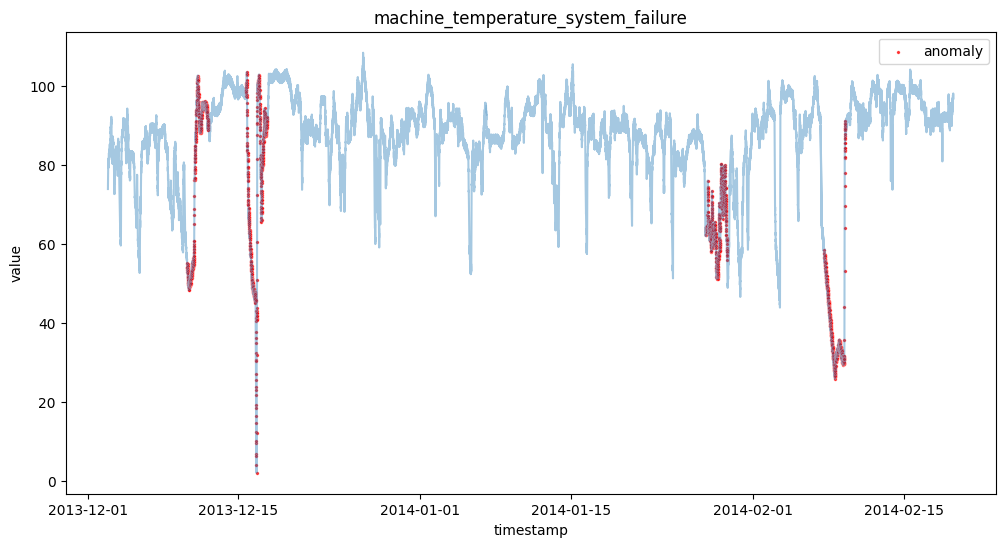

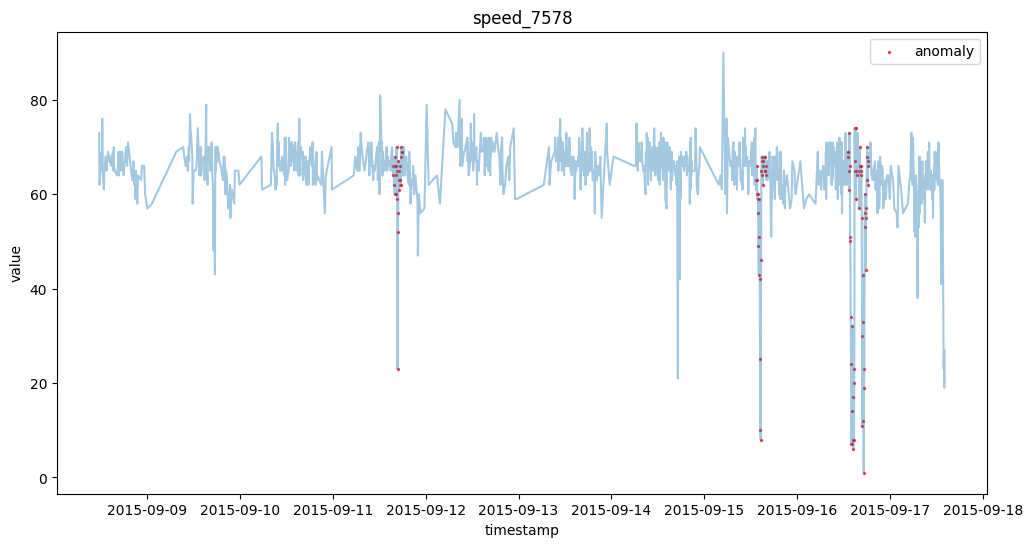

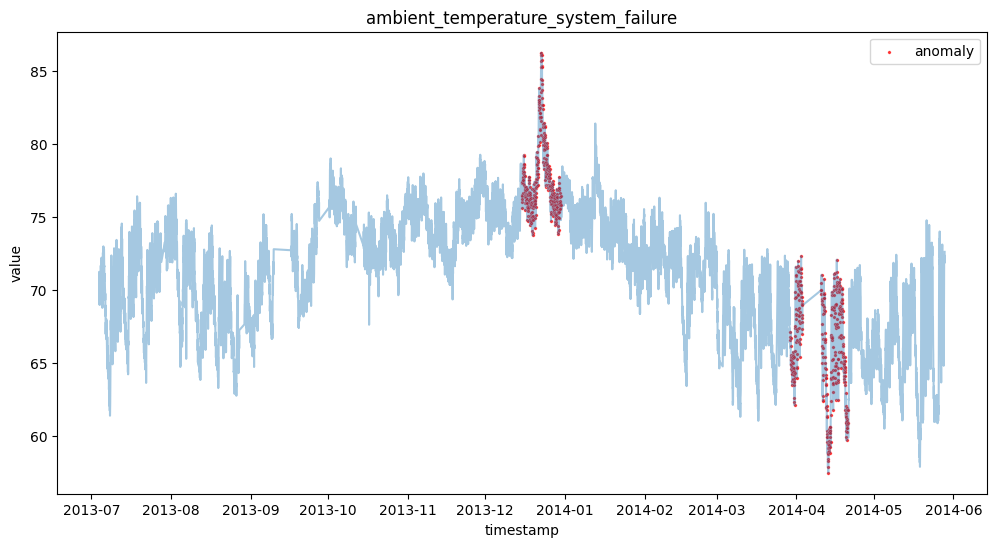

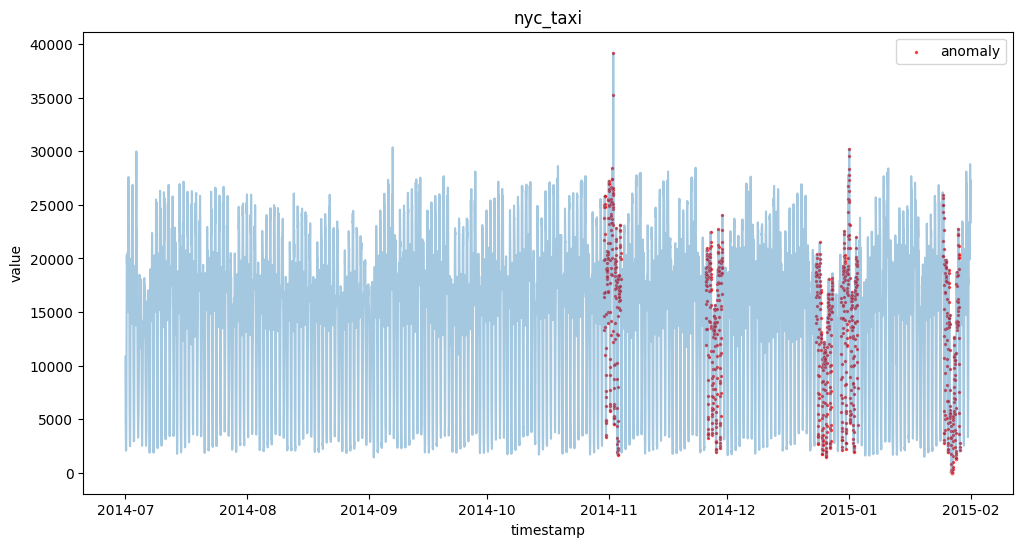

In [20]:
for ds_obj, dataset in obj2name:
    fig, axs = plt.subplots(figsize=(12, 6))
    sns.lineplot(x="timestamp", y="value", data=ds_obj, alpha=0.4)
    sns.scatterplot(
        x="timestamp",
        y="value",
        data=ds_obj[ds_obj["anomaly"] == 1],
        color="red",
        label="anomaly",
        alpha=0.8,
        s=6,
    )
    plt.title(dataset.split("/")[-1].split(".")[0])
    plt.show()

# save processed versions

In [26]:
# save processed dataframes to DATA_DIR/processed
for ds_obj, dataset in obj2name:
    ds_obj.to_parquet(
        DATA_DIR / f'processed_{dataset.split("/")[-1].split(".")[0]}.parquet',
        index=False,
    )

# Plots

In [64]:
df = pd.read_parquet(DATA_DIR / "processed_nyc_taxi.parquet")
# df.set_index("timestamp", inplace=True)

In [65]:
df.head()

,timestamp,value,anomaly
0,2014-07-01 00:00:00,10844,0
1,2014-07-01 00:30:00,8127,0
2,2014-07-01 01:00:00,6210,0
3,2014-07-01 01:30:00,4656,0
4,2014-07-01 02:00:00,3820,0


In [66]:
df.tail()

,timestamp,value,anomaly
10315,2015-01-31 21:30:00,24670,0
10316,2015-01-31 22:00:00,25721,0
10317,2015-01-31 22:30:00,27309,0
10318,2015-01-31 23:00:00,26591,0
10319,2015-01-31 23:30:00,26288,0


In [67]:
df.query("anomaly==1").head()

,timestamp,value,anomaly
5839,2014-10-30 15:30:00,16749,1
5840,2014-10-30 16:00:00,14604,1
5841,2014-10-30 16:30:00,13367,1
5842,2014-10-30 17:00:00,16382,1
5843,2014-10-30 17:30:00,19879,1


In [74]:
# select a day with anomalies
g = df[df.timestamp.between("2014-10-15", "2014-11-15")]

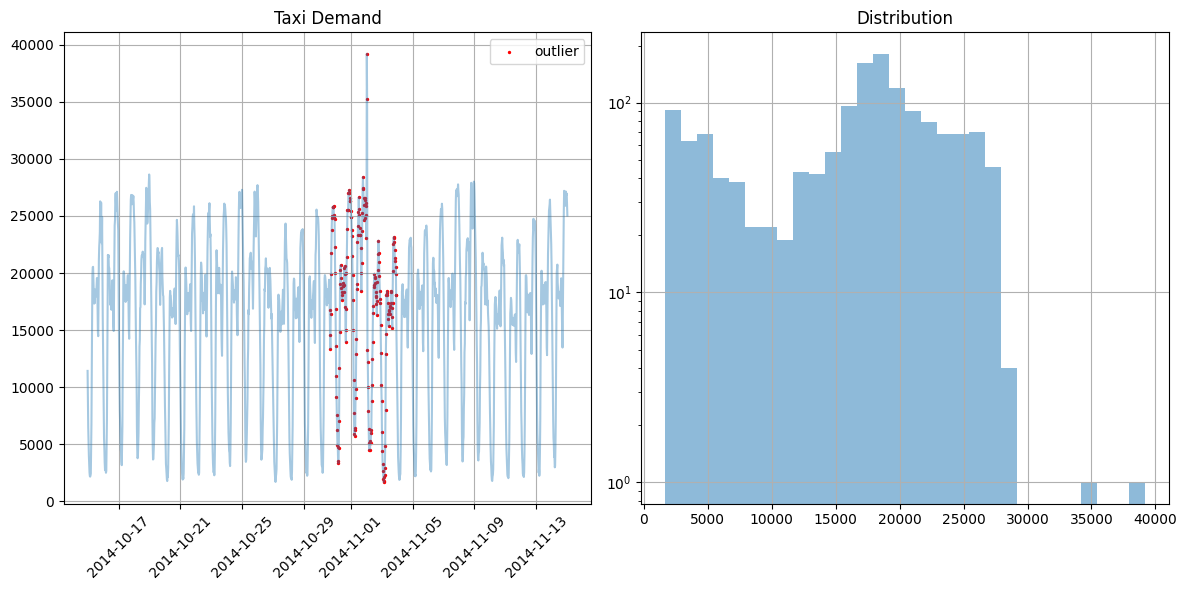

In [91]:
x = g["value"].to_numpy()
d = g["timestamp"].to_numpy()
outliers_pos = np.where(g["anomaly"].to_numpy())[0]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
# fig.suptitle(f'NYC Taxi demand - anomalies highlighted in red')
plt.subplot(1, 2, 1)
sns.lineplot(x="timestamp", y="value", data=g, alpha=0.4)
plt.xticks(rotation=45)
plt.ylabel("")
plt.xlabel("")
plt.title("Taxi Demand")
# plot outliers
for outlier_pos in outliers_pos:
    plt.scatter(d[outlier_pos], x[outlier_pos], color="red", s=2, zorder=1)
# for legend
plt.scatter(d[outlier_pos], x[outlier_pos], color="red", s=2, label="outlier", zorder=1)
plt.legend()
plt.grid(visible=True)
plt.subplot(1, 2, 2)
plt.hist(x, bins=30, alpha=0.5)
plt.yscale("log")
plt.title("Distribution")
plt.grid(visible=True)

plt.tight_layout()
plt.plot()
plt.savefig(f"../tex/Figures/NAB_example_nyc_taxi.png")